# 🏘 Задача предсказания стоимости жилья

На этом семинаре мы:
* Вспомним, что такое переобучение и как его не допустить;
* Обучим линейную регрессию для предсказания цены дома;
* Поработаем с разными типами признаков;
* Рассмотрим отличия между разными регуляризаторами;


## Импорт библиотек, настройка ноутбука

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [ ]:
sns.set_style("whitegrid")
sns.set_palette("Set2")

# Этап 0. Напоминание о переобучении

На втором занятии мы говорили о причинах переобучения моделей. Рассмотрим это явление детальнее.

Напомним, что линейная регрессия &mdash; это модель следующего вида:

$$a(x) = \langle w, x \rangle + w_0$$

где $w \in \mathbb{R}^d$, $w_0 \in \mathbb{R}$. Обучить линейную регрессию &mdash; значит найти $w$ и $w_0$.

В машинном обучении часто говорят об *обобщающей способности модели*, то есть о способности модели работать на новых, тестовых данных хорошо. Если модель будет идеально предсказывать выборку, на которой она обучалась, но при этом просто ее запомнит, не "вытащив" из данных никакой закономерности, от нее будет мало толку. Такую модель называют *переобученной*: она слишком подстроилась под обучающие примеры, не выявив никакой полезной закономерности, которая позволила бы ей совершать хорошие предсказания на данных, которые она ранее не видела.

Рассмотрим следующий пример, на котором будет хорошо видно, что значит переобучение модели. Для этого сгенерируем синтетические данные. Рассмотрим зависимость $y(x) = \cos(1.5\pi x)$, $y$ &mdash; целевая переменная, а $x$ - объект (просто число от 0 до 1). В жизни мы наблюдаем какое-то конечное количество пар объект-таргет, поэтому смоделируем это, взяв 30 случайных точек $x_i$ в отрезке $[0;1]$. Более того, в реальной жизни целевая переменная может быть зашумленной (измерения в жизни не всегда точны), смоделируем это, зашумив значение функции нормальным шумом: $\tilde{y}_i = y(x_i) + \mathcal{N}(0, 0.01)$.

Попытаемся обучить три разных линейных модели: признаки для первой &mdash;  $\{x\}$, для второй &mdash; $\{x, x^2, x^3, x^4\}$, для третьей &mdash; $\{x, \dots, x^{20}\}$.

1 [-1.96635465]
4 [  0.0697848  -14.40575795  18.10888186  -4.68598787]
20 [-1.78991008e+02  1.67521418e+04 -6.05380735e+05  1.13078856e+07
 -1.27356527e+08  9.40795395e+08 -4.77739123e+09  1.70621185e+10
 -4.29341220e+10  7.41168294e+10 -8.00155413e+10  3.50516092e+10
  3.21329456e+10 -5.31814242e+10  1.03348571e+10  3.63584147e+10
 -3.90311520e+10  1.67756484e+10 -2.64479616e+09 -7.21552318e+07]


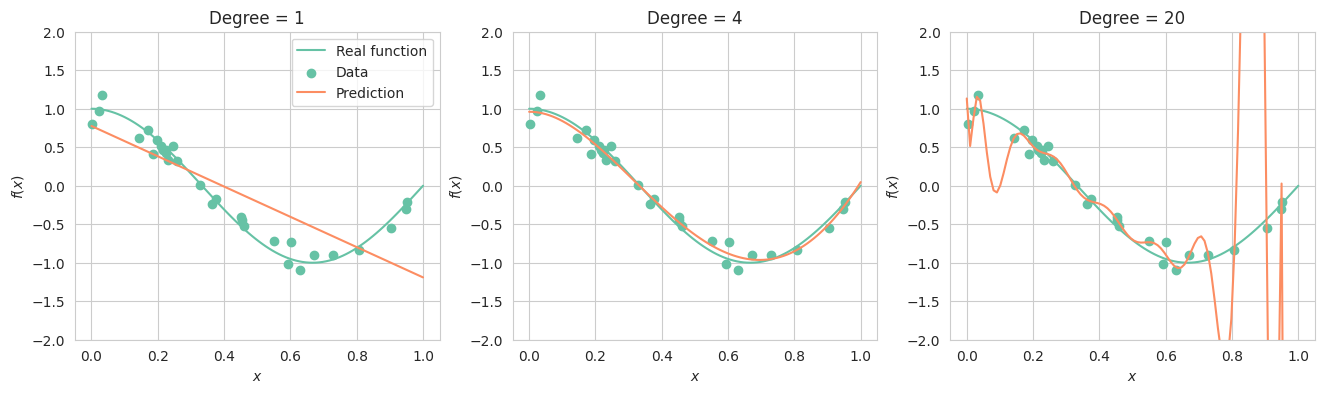

In [ ]:
from sklearn.linear_model import LinearRegression

np.random.seed(36)
x = np.linspace(0, 1, 100)
y = np.cos(1.5 * np.pi * x)

x_objects = np.random.uniform(0, 1, size=30)
y_objects = np.cos(1.5 * np.pi * x_objects) + np.random.normal(scale=0.1, size=x_objects.shape)

from sklearn.preprocessing import PolynomialFeatures
fig, axs = plt.subplots(figsize=(16, 4), ncols=3)
for i, degree in enumerate([1, 4, 20]):
    X_objects = PolynomialFeatures(degree, include_bias=False).fit_transform(x_objects[:, None])
    X = PolynomialFeatures(degree, include_bias=False).fit_transform(x[:, None])
    regr = LinearRegression().fit(X_objects, y_objects)
    y_pred = regr.predict(X)
    axs[i].plot(x, y, label="Real function")
    axs[i].scatter(x_objects, y_objects, label="Data")
    axs[i].plot(x, y_pred, label="Prediction")
    if i == 0:
        axs[i].legend()
    axs[i].set_title(f"Degree = {degree}")
    axs[i].set_xlabel("$x$")
    axs[i].set_ylabel("$f(x)$")
    axs[i].set_ylim(-2, 2)
    print(degree, regr.coef_)
# полином двадцатой степени
# x + x^2 + x^3 + x^4

**Вопрос 1**: Почему первая модель получилась плохой, а третья переобучилась?

Чтобы избежать переобучения, модель регуляризуют. Обычно переобучения в линейных моделях связаны с большими весами, а поэтому модель часто штрафуют за большие значения весов, добавляя к функционалу качества, например, квадрат $\ell^2$-нормы вектора $w$:

$$Q_{reg}(X, y, a) = Q(X, y, a) + \lambda \|w\|_2^2$$

Это слагаемое называют $\ell_2$-регуляризатором, а коэффициент $\lambda$ &mdash; коэффициентом регуляризации.

**Вопрос 2**: Почему большие веса в линейной модели &mdash; плохо?

**Вопрос 3**: Почему регуляризовать $w_0$ &mdash; плохая идея?

**Вопрос 4**: На что влияет коэффициент $\lambda$? Что будет происходить с моделью, если $\lambda$ начать уменьшать? Что будет, если $\lambda$ сделать слишком большим?

# Этап I: EDA

Мы будем работать с данными из соревнования [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview), в котором требовалось предсказать стоимость жилья. Давайте сначала загрузим и немного изучим данные (можно взять `train.csv` со страницы соревнования и переименовать в `train_sem.csv`).

In [ ]:
# Загружаем данные
!wget  -O 'train_sem.csv' -q 'https://www.dropbox.com/s/6dxq90t0prn2vaw/_train_sem2.csv?dl=0'

In [ ]:
data = pd.read_csv("train_sem.csv")
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
data.shape

(1460, 81)

In [ ]:
data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

Первое, что стоит заметить &mdash; у нас в данных есть уникальное для каждого объекта поле id. Обычно такие поля только мешают и *способствуют переобучению*. Удалим это поле из данных.

Разделим данные на обучающую и тестовую выборки. Для простоты не будем выделять дополнительно валидационную выборку (хотя это обычно стоит делать, она нужна для подбора гиперпараметров модели, то есть параметров, которые нельзя подбирать по обучающей выборке). Дополнительно нам придется отделить значения целевой переменной от данных.

**Вопрос 1**: Почему поля типа id могут вызвать переобучение модели (не обязательно линейной)?

**Вопрос 2**: Почему стоит дополнительно отделять валидационную выборку?

**Вопрос 3**: Обратите внимание на фиксацию `random_state` при сплите данных. Почему это важно?

In [ ]:
from sklearn.model_selection import train_test_split

data = data.drop(columns=["Id"])

y = data["SalePrice"]
X = data.drop(columns=["SalePrice"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

Посмотрим сначала на значения целевой переменной.

In [ ]:
X.shape

(1460, 79)

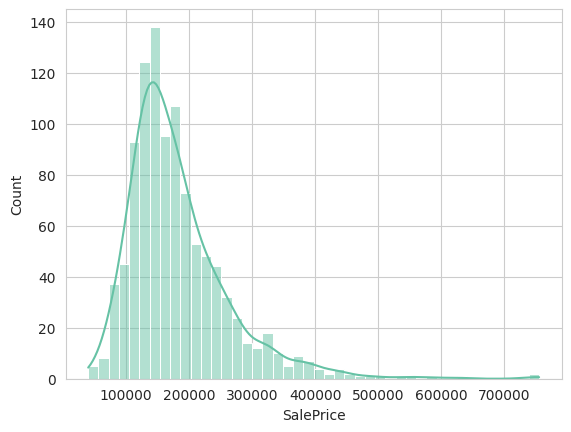

In [ ]:
sns.histplot(y_train, kde=True);

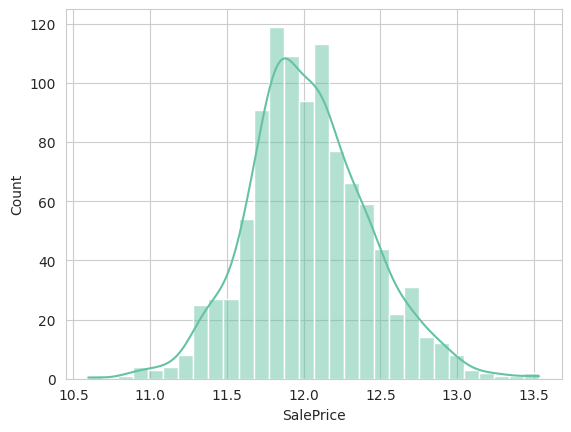

In [ ]:
# Логарифмируем целевую переменную
sns.histplot(np.log(y_train), kde=True);

Судя по гистограмме, у нас есть примеры с нетипично большой стоимостью, что может помешать нам, если наша функция потерь слишком чувствительна к выбросам. В дальнейшем мы рассмотрим способы, как минимизировать ущерб от этого.

Так как для решения нашей задачи мы бы хотели обучить линейную регрессию, было бы хорошо найти признаки, "наиболее линейно" связанные с целевой переменной, иначе говоря, посмотреть на коэффициент корреляции Пирсона между признаками и целевой переменной. Заметим, что не все признаки являются числовыми. На данном этапе поработаем только с числовыми, к остальным вернемся позже.

**Вопрос**: Что означает, что коэффициент корреляции Пирсона между двумя случайными величинами равен 1? -1? 0?

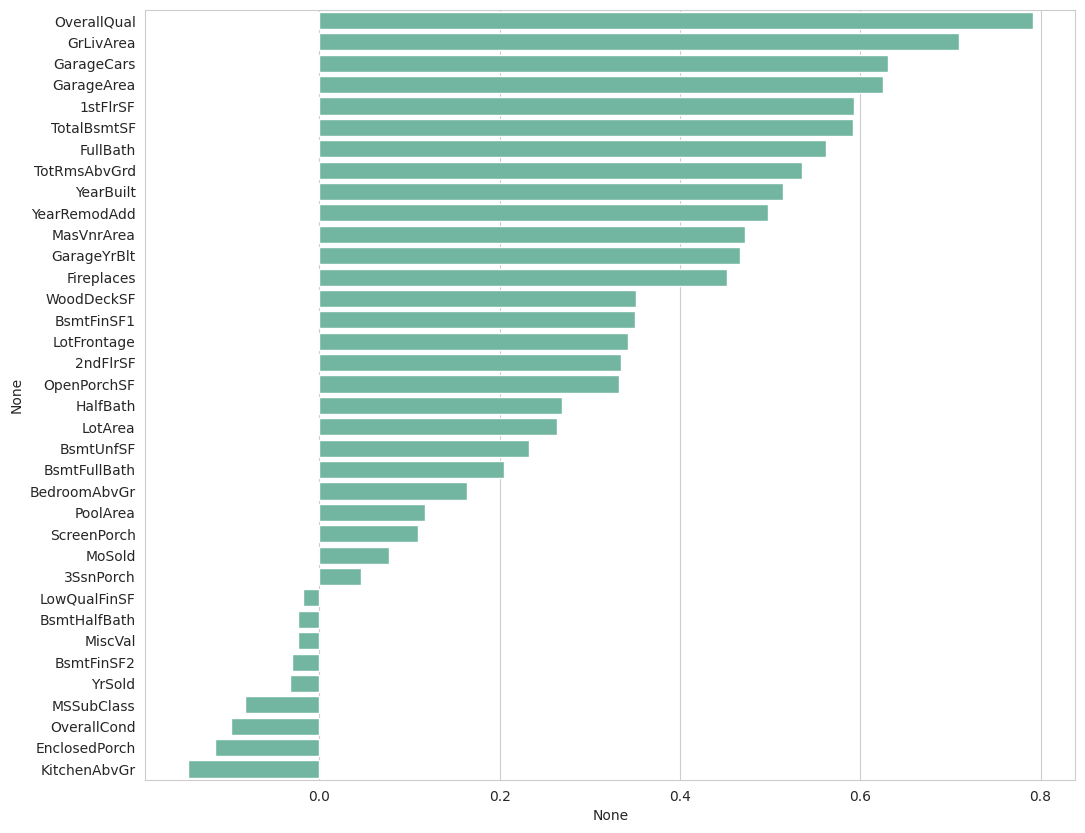

In [ ]:
numeric_data = X_train.select_dtypes([np.number])
numeric_data_mean = numeric_data.mean()
numeric_features = numeric_data.columns

X_train = X_train.fillna(numeric_data_mean) # заполняет пропуски средним
X_test = X_test.fillna(numeric_data_mean)

correlations = X_train[numeric_features].corrwith(y_train).sort_values(ascending=False)


plot = sns.barplot(y=correlations.index, x=correlations)
plot.figure.set_size_inches(12, 10)

Посмотрим на признаки из начала списка. Для этого нарисуем график зависимости целевой переменной от каждого из признаков. На этом графике каждая точка соответствует паре признак-таргет (такие графики называются scatter-plot).


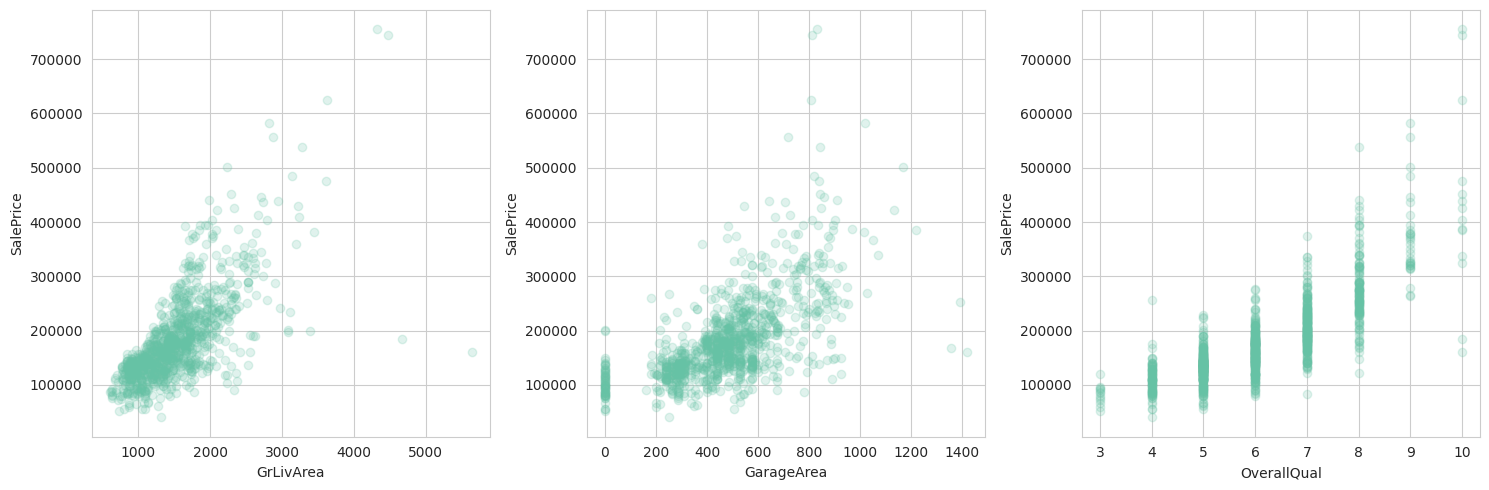

In [ ]:
fig, axs = plt.subplots(figsize=(15, 5), ncols=3)
for i, feature in enumerate(["GrLivArea", "GarageArea", "OverallQual"]):
    axs[i].scatter(X_train[feature], y_train, alpha=0.2)
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel("SalePrice")
plt.tight_layout()

Видим, что между этими признаками и целевой переменной действительно наблюдается линейная зависимость.

# Этап II. Обучение на числовых признаках

## Baseline (линейная регрессия)

*Немного об обучении моделей*. В арсенале дата-саентиста кроме `pandas` и `matplotlib` должны быть библиотеки, позволяющие обучать модели. Для простых моделей (линейные модели, решающее дерево, ...) отлично подходит `sklearn`: в нем очень понятный и простой интерфейс. Несмотря на то, что в `sklearn` есть реализация бустинга и простых нейронных сетей, ими все же не пользуются и предпочитают специализированные библиотеки: `XGBoost`, `LightGBM` и пр. для градиентного бустинга над деревьями, `PyTorch`, `Tensorflow` и пр. для нейронных сетей. Так как мы будем обучать линейную регрессию, нам подойдет реализация из `sklearn`.

Попробуем обучить линейную регрессию на числовых признаках из нашего датасета. В `sklearn` есть несколько классов, реализующих линейную регрессию:
* [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) &mdash; "классическая" линейная регрессия с оптимизацией MSE. Веса находятся как точное решение: $w^* = (X^TX)^{-1}X^Ty$
* [`Ridge`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) &mdash; линейная регрессия с оптимизацией MSE и $\ell_2$-регуляризацией
* [`Lasso`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) &mdash; линейная регрессия с оптимизацией MSE и $\ell_1$-регуляризацией

Напомним, что у моделей из `sklearn` есть методы `fit` и `predict`. Первый принимает на вход обучающую выборку и вектор целевых переменных и обучает модель, второй, будучи вызванным после обучения модели, возвращает предсказание на выборке. Попробуем обучить нашу первую модель на числовых признаках, которые у нас сейчас есть:

In [ ]:
from sklearn.metrics import mean_squared_error, root_mean_squared_error

model = LinearRegression()
model.fit(X_train[numeric_features], y_train)
y_pred = model.predict(X_test[numeric_features])
y_train_pred = model.predict(X_train[numeric_features])

print("Test MSE = %.4f" % mean_squared_error(y_test, y_pred))
print("Train MSE = %.4f" % mean_squared_error(y_train, y_train_pred))

print("Test RMSE = %.4f" % root_mean_squared_error(y_test, y_pred))
print("Train RMSE = %.4f" % root_mean_squared_error(y_train, y_train_pred))

Test MSE = 1030194259.9688
Train MSE = 1269579719.0937
Test RMSE = 32096.6394
Train RMSE = 35631.1622


Посмотрим на коэффициент детерминации $R^2$. Как мы помним, $R^2$ — это нормализованая MSE, которая показывает, насколько хорошо модель объясняет данные. Чем ближе значение метрики к 1, тем лучше.

In [ ]:
from sklearn.metrics import r2_score
print("R2 = %.4f" % r2_score(y_test, y_pred))

R2 = 0.8242


Для того чтобы посмотреть, нет ли у нас переобучения, можно проверить полученные веса модели

In [ ]:
model.coef_

array([-1.89194870e+02, -1.23582308e+02,  4.18052096e-01,  1.84783494e+04,
        4.87755718e+03,  3.08692817e+02,  1.18673028e+02,  3.09963926e+01,
        7.74888325e+00, -6.26689256e+00,  2.55321819e-01,  1.73731252e+00,
        2.01999400e+01,  2.10833980e+01, -8.44329763e+00,  3.28400405e+01,
        1.09022513e+04,  5.63703925e+03,  3.92250714e+03, -5.64478534e+03,
       -8.80528761e+03, -1.34541529e+04,  4.67547248e+03,  3.00942034e+03,
        9.62842791e+01,  1.34581469e+04, -1.05581038e+01,  3.60037761e+01,
       -7.82903341e-01,  1.30141538e+01,  3.84545919e+01,  6.07846455e+01,
       -1.10895151e+01, -1.83435502e-01,  1.59265979e+02, -8.28837215e+02])

Для удобства можем отсортировать веса

In [ ]:
sorted(model.coef_)

[np.float64(-13454.152922041518),
 np.float64(-8805.287607883756),
 np.float64(-5644.785339648579),
 np.float64(-828.8372154579622),
 np.float64(-189.1948695745421),
 np.float64(-123.58230809472768),
 np.float64(-11.089515111246506),
 np.float64(-10.558103802406723),
 np.float64(-8.443297626646155),
 np.float64(-6.2668925610281745),
 np.float64(-0.7829033411892121),
 np.float64(-0.18343550164856492),
 np.float64(0.2553218190959707),
 np.float64(0.4180520958254661),
 np.float64(1.7373125156372784),
 np.float64(7.748883254897908),
 np.float64(13.014153815583853),
 np.float64(20.19994004908154),
 np.float64(21.08339803530768),
 np.float64(30.996392628423788),
 np.float64(32.84004045284059),
 np.float64(36.003776116201095),
 np.float64(38.45459190227385),
 np.float64(60.78464551630842),
 np.float64(96.28427912057586),
 np.float64(118.67302842892393),
 np.float64(159.26597874993428),
 np.float64(308.69281720976113),
 np.float64(3009.420342498296),
 np.float64(3922.507135491046),
 np.float64

В выведенных весах:  
* Наименьшие значения - признаки с самым сильным отрицательным влиянием

* Наибольшие значения - признаки с самым сильным положительным влиянием

* Близкие к нулю - маловажные признаки

## Кросс-валидация

Мы обучили первую модель и даже посчитали ее качество на отложенной выборке! Давайте теперь посмотрим на то, как можно оценить качество модели с помощью кросс-валидации.

При кросс-валидации мы делим обучающую выборку на $n$ частей (fold). Затем мы обучаем $n$ моделей: каждая модель обучается при отсутствии соответствующего фолда, то есть $i$-ая модель обучается на всей обучающей выборке, кроме объектов, которые попали в $i$-ый фолд (out-of-fold). Затем мы измеряем качество $i$-ой модели на $i$-ом фолде. Так как он не участвовал в обучении этой модели, мы получим "честный результат". После этого, для получения финального значения метрики качества, мы можем усреднить полученные нами $n$ значений.

In [ ]:
from sklearn.model_selection import cross_val_score

model = LinearRegression()
cv_scores = cross_val_score(model,
                            X_train[numeric_features],
                            y_train,
                            cv=10, # k=5, 7, 10
                            scoring="neg_root_mean_squared_error")
print("Cross validation scores:\n\t",
      "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV RMSE = %.4f" % np.mean(-cv_scores))

Cross validation scores:
	 -38812.2320
	-45298.2347
	-31401.3597
	-33906.2280
	-73842.3895
	-24154.2978
	-45535.1469
	-52851.8138
	-26127.9001
	-29708.7603
Mean CV RMSE = 40163.8363


Обратите внимание на то, что результаты `cv_scores` получились отрицательными. Это соглашение в `sklearn` (скоринговую функцию нужно максимизировать). Поэтому все стандартные скореры называются `neg_*`, например, `neg_root_mean_squared_error`.

Обратите внимание, что по отложенной выборке и при кросс-валидации мы считаем RMSE (Root Mean Squared Error), хотя в функционале ошибки при обучении модели используется MSE.


**Вопрос**: Почему оптимизация RMSE эквивалентна оптимизации MSE?

*Небольшое отступление*

Если бы RMSE не входил в стандартные метрики `sklearn`, можно было бы его определить через функцию `sklearn.metrics.make_scorer`. Документация на сайте [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html)

In [ ]:
from sklearn.metrics import make_scorer

def rmse(y_true, y_pred):
    error = (y_true - y_pred) ** 2
    return np.sqrt(np.mean(error))

rmse_scorer = make_scorer(
    rmse,
    greater_is_better=False
)

In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    model, X_train[numeric_features], y_train, cv=10, scoring=rmse_scorer)
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV RMSE = %.4f" % np.mean(-cv_scores))

Cross validation scores:
	 -38812.2320
	-45298.2347
	-31401.3597
	-33906.2280
	-73842.3895
	-24154.2978
	-45535.1469
	-52851.8138
	-26127.9001
	-29708.7603
Mean CV RMSE = 40163.8363


Для того, чтобы иметь некоторую точку отсчета, удобно посчитать оптимальное значение функции потерь при константном предсказании.

**Вопрос**: Чему равна оптимальная константа для RMSE?

In [ ]:
best_constant = y_train.mean()
print("Test RMSE with best constant = %.4f" % root_mean_squared_error(
    y_test, best_constant * np.ones(y_test.shape)))
print("Train RMSE with best constant = %.4f" % root_mean_squared_error(
    y_train, best_constant * np.ones(y_train.shape)))

Test RMSE with best constant = 76636.5188
Train RMSE with best constant = 80588.6191


Давайте посмотрим на то, какие же признаки оказались самыми "сильными". Для этого визуализируем веса, соответствующие признакам. Чем больше вес &mdash; тем более сильным является признак.

**Вопрос**: Почему это не совсем правда?

In [ ]:
model = LinearRegression()
model.fit(X_train[numeric_features], y_train)

LinearRegression()

In [ ]:
def show_weights(features, weights, scales):
    fig, axs = plt.subplots(figsize=(14, 10), ncols=2)
    sorted_weights = sorted(zip(weights, features, scales), reverse=True)
    weights = [x[0] for x in sorted_weights]
    features = [x[1] for x in sorted_weights]
    scales = [x[2] for x in sorted_weights]
    sns.barplot(y=features, x=weights, ax=axs[0])
    axs[0].set_xlabel("Weight")
    sns.barplot(y=features, x=scales, ax=axs[1])
    axs[1].set_xlabel("Scale")
    plt.tight_layout()

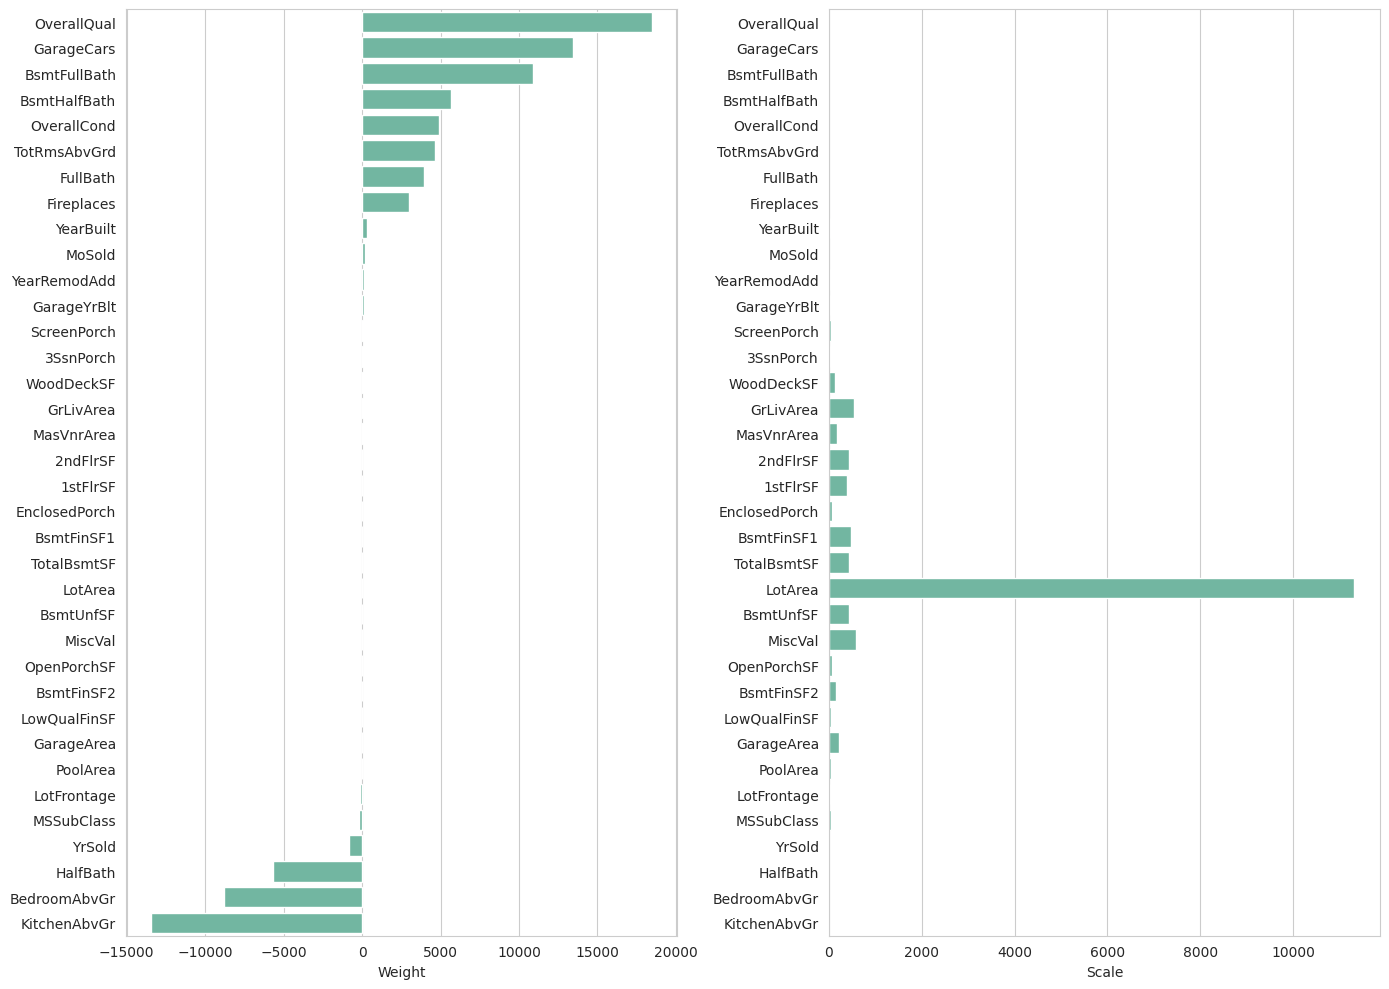

In [ ]:
show_weights(numeric_features, model.coef_, X_train[numeric_features].std())

## Масштабирование

Будем масштабировать наши признаки перед обучением модели. Это, среди, прочего, сделает нашу регуляризацию более честной: теперь все признаки будут регуляризоваться в равной степени.

Для этого воспользуемся трансформером [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). Трансформеры в `sklearn` имеют методы `fit` и `transform` (а еще `fit_transform`). Метод `fit` принимает на вход обучающую выборку и считает по ней необходимые значения (например статистики, как `StandardScaler`: среднее и стандартное отклонение каждого из признаков). `transform` применяет преобразование к переданной выборке.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_features])
X_test_scaled = scaler.transform(X_test[numeric_features])

model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
y_train_pred = model.predict(X_train_scaled)

print("Test RMSE = %.4f" % root_mean_squared_error(y_test, y_pred))
print("Train RMSE = %.4f" % root_mean_squared_error(y_train, y_train_pred))

Test RMSE = 32096.6394
Train RMSE = 35631.1622


In [ ]:
sorted(model.coef_)

[np.float64(-8041.041298533779),
 np.float64(-7186.235856590038),
 np.float64(-2851.6699045354735),
 np.float64(-2851.426966128961),
 np.float64(-2760.31726985884),
 np.float64(-2278.1857869498263),
 np.float64(-1240.9665103917525),
 np.float64(-1088.8236613807853),
 np.float64(-769.876775883651),
 np.float64(-448.13891639173744),
 np.float64(-263.8224095656597),
 np.float64(-107.36859831963893),
 np.float64(-51.80801982400587),
 np.float64(435.22825489242297),
 np.float64(804.1310825705567),
 np.float64(1232.596362099043),
 np.float64(1296.2350279616967),
 np.float64(1653.8425431811006),
 np.float64(1938.1022321857354),
 np.float64(2153.331498597709),
 np.float64(2318.2034877122182),
 np.float64(2447.8705302661024),
 np.float64(2692.960477007827),
 np.float64(3122.757958868226),
 np.float64(4512.499020464284),
 np.float64(4723.95731401325),
 np.float64(5301.748025845337),
 np.float64(5638.774296169709),
 np.float64(5779.737474004293),
 np.float64(7469.9783457318235),
 np.float64(9336.

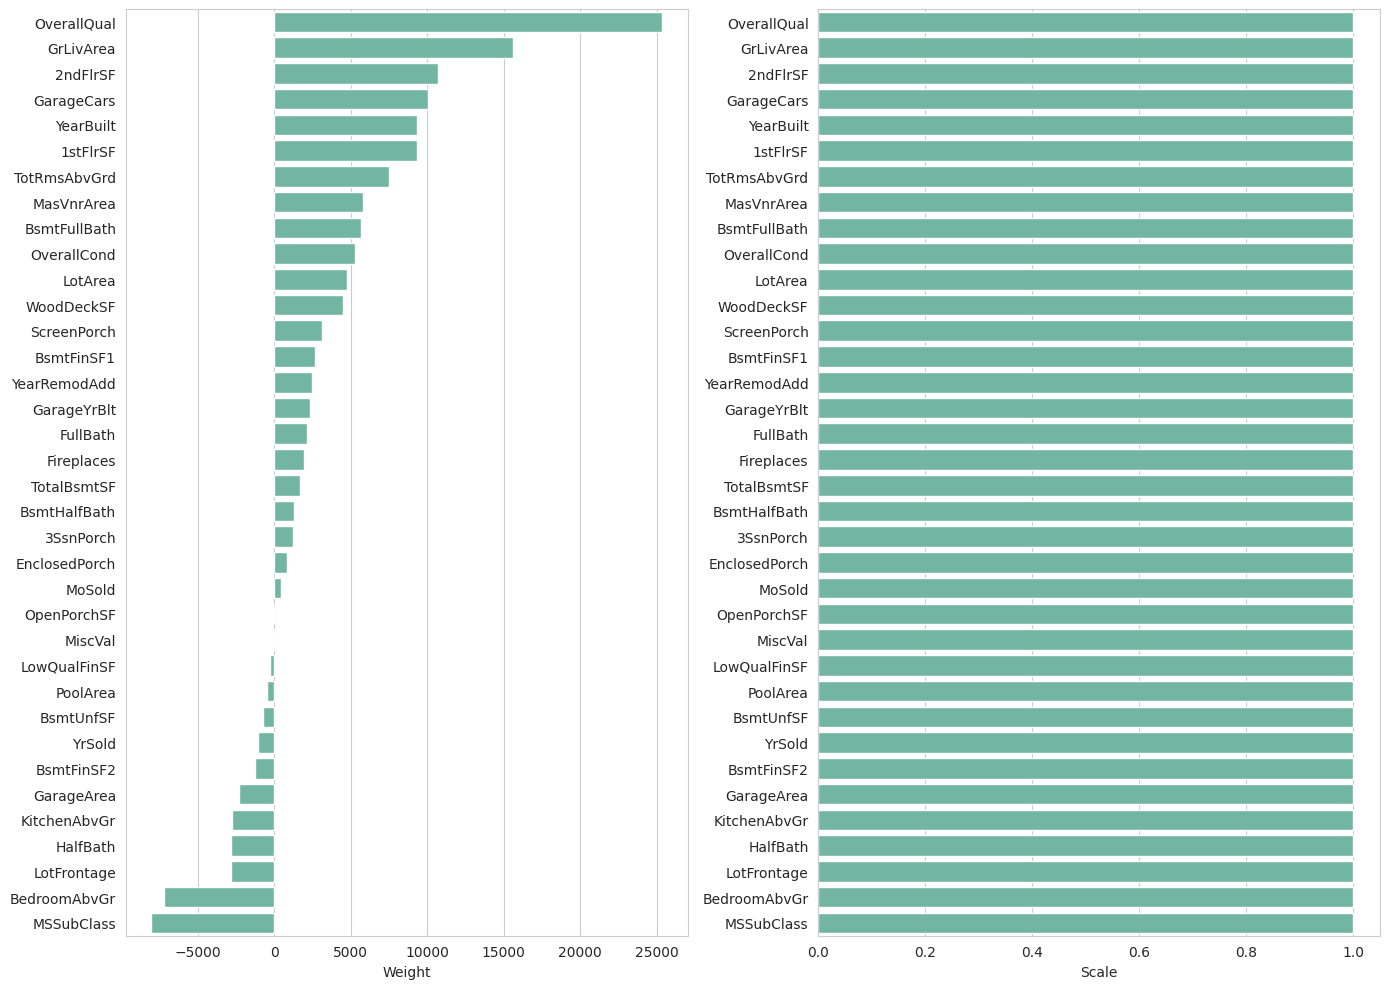

In [ ]:
scales = pd.Series(data=X_train_scaled.std(axis=0), index=numeric_features)
show_weights(numeric_features, model.coef_, scales)

## Ridge

Наряду с параметрами (веса $w$, $w_0$), которые модель оптимизирует на этапе обучения, у модели есть и гиперпараметры. У нашей модели это `alpha` &mdash; коэффициент регуляризации. Подбирают его обычно по сетке, измеряя качество на валидационной (не тестовой) выборке или с помощью кросс-валидации. Посмотрим, как это можно сделать (заметьте, что мы перебираем `alpha` по логарифмической сетке, чтобы узнать оптимальный порядок величины).

Best alpha = 297.6351


Text(0, 0.5, 'CV score')

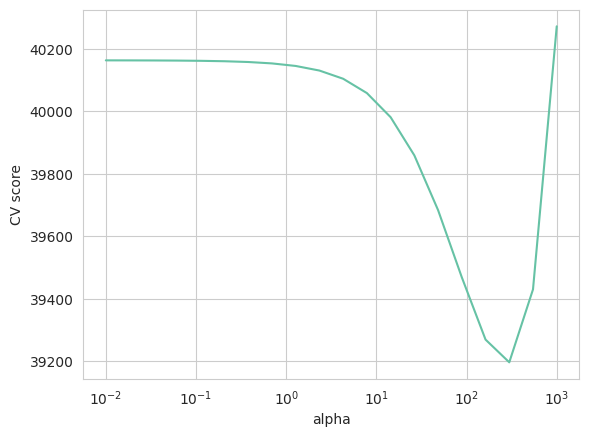

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

alphas = np.logspace(-2, 3, 20)
searcher = GridSearchCV(Ridge(), [{
    "alpha": alphas
}],
                        scoring="neg_root_mean_squared_error",
                        cv=10)
searcher.fit(X_train_scaled, y_train)

best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

**Вопрос**: Почему мы не подбираем коэффициент регуляризации по обучающей выборке? По тестовой выборке?

Попробуем обучить модель с подобранным коэффициентом регуляризации. Заодно воспользуемся очень удобным классом [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): обучение модели часто представляется как последовательность некоторых действий с обучающей и тестовой выборками (например, сначала нужно отмасштабировать выборку (причем для обучающей выборки нужно применить метод `fit`, а для тестовой &mdash; `transform`), а затем обучить/применить модель (для обучающей `fit`, а для тестовой &mdash; `predict`). `Pipeline` позволяет хранить эту последовательность шагов и корректно обрабатывает разные типы выборок: и обучающую, и тестовую.

In [ ]:
from sklearn.pipeline import Pipeline

simple_pipeline = Pipeline([
    ('scaling', StandardScaler()),
    ('regression', Ridge(best_alpha))
])

model = simple_pipeline.fit(X_train[numeric_features], y_train)
y_pred = model.predict(X_test[numeric_features])
print("Test RMSE = %.4f" % root_mean_squared_error(y_test, y_pred))

Test RMSE = 31703.3590


# Этап III. Обучение на полном датасете

Сейчас мы явно вытягивали из данных не всю информацию, что у нас есть, просто потому, что мы не использовали часть признаков. Эти признаки в датасете закодированы строками, каждый из них обозначает некоторую категорию. Такие признаки называются категориальными. Давайте выделим такие признаки и сразу заполним пропуски в них специальным значением (то, что у признака пропущено значение, само по себе может быть хорошим признаком).

## Обработка категориальных признаков

In [ ]:
categorical = list(X_train.dtypes[X_train.dtypes == "object"].index)
X_train[categorical] = X_train[categorical].fillna("NotGiven")
X_test[categorical] = X_test[categorical].fillna("NotGiven")

In [ ]:
len(numeric_features)

36

In [ ]:
len(categorical)

43

In [ ]:
X_train[categorical].sample(5)

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
184,RL,Pave,NotGiven,IR1,Lvl,AllPub,Inside,Gtl,BrkSide,RRAn,...,Attchd,Unf,TA,TA,Y,NotGiven,MnPrv,NotGiven,WD,Normal
837,RM,Pave,NotGiven,Reg,Lvl,AllPub,Inside,Gtl,BrDale,Norm,...,Detchd,Unf,TA,TA,Y,NotGiven,NotGiven,NotGiven,WD,Normal
1094,RL,Pave,NotGiven,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Fin,TA,TA,Y,NotGiven,NotGiven,NotGiven,WD,Normal
1291,RM,Pave,NotGiven,Reg,Lvl,AllPub,Inside,Gtl,BrDale,Norm,...,Detchd,Unf,TA,TA,Y,NotGiven,NotGiven,NotGiven,WD,Normal
436,RM,Pave,NotGiven,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,...,Detchd,Unf,TA,TA,Y,NotGiven,NotGiven,NotGiven,WD,Normal


Сейчас нам нужно как-то закодировать эти категориальные признаки числами, ведь линейная модель не может работать с такими абстракциями. Два стандартных трансформера из `sklearn` для работы с категориальными признаками &mdash; [`OrdinalEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) (просто перенумеровывает значения признака натуральными числами) и [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).

`OneHotEncoder` ставит в соответствие каждому признаку целый вектор, состоящий из нулей и одной единицы (которая стоит на месте, соответствующем принимаемому значению, таким образом кодируя его).

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % root_mean_squared_error(y_test, y_pred))

Test RMSE = 26071.0846


**Вопрос**: Почему мы не производим скейлинг OneHot-кодированных признаков?

Посмотрим на размеры матрицы после OneHot-кодирования:

In [ ]:
print("Size before OneHot:", X_train.shape)
print("Size after OneHot:", column_transformer.transform(X_train).shape)

Size before OneHot: (1022, 79)
Size after OneHot: (1022, 293)


## Lasso

Как видим, количество признаков увеличилось более, чем в 3 раза. Это может повысить риски переобучиться: соотношение количества объектов к количеству признаков сильно сократилось.

Попытаемся обучить линейную регрессию с $\ell_1$-регуляризатором, который разреживает признаковое пространство (зануляет часть весов).

In [ ]:
from sklearn.linear_model import Lasso

#l1 регуляризатор |w|
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

lasso_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso())
])

model = lasso_pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("RMSE = %.4f" % root_mean_squared_error(y_test, y_pred))

RMSE = 26446.7638


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1106357423.6835327, tolerance: 663740509.6745819
  model = cd_fast.sparse_enet_coordinate_descent(


In [ ]:
ridge_zeros = np.sum(pipeline.steps[-1][-1].coef_ == 0)
lasso_zeros = np.sum(lasso_pipeline.steps[-1][-1].coef_ == 0)
print("Zero weights in Ridge:", ridge_zeros)
print("Zero weights in Lasso:", lasso_zeros)

Zero weights in Ridge: 0
Zero weights in Lasso: 29


Подберем для нашей модели оптимальный коэффициент регуляризации. Обратите внимание, как перебираются параметры у `Pipeline`.

Best alpha = 263.6651


Text(0, 0.5, 'CV score')

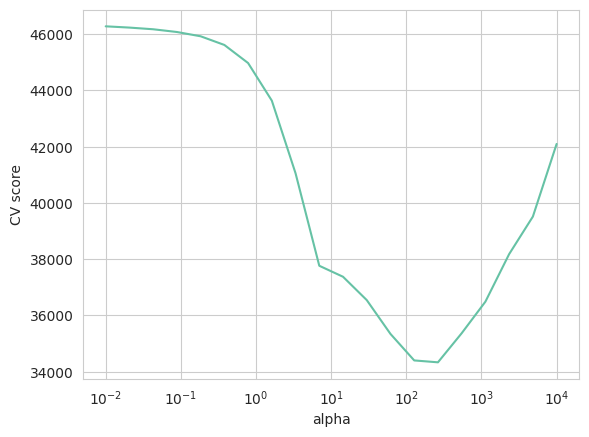

In [ ]:
alphas = np.logspace(-2, 4, 20)
searcher = GridSearchCV(lasso_pipeline, [{"regression__alpha": alphas}],
                        scoring="neg_root_mean_squared_error", cv=10, n_jobs=-1)
searcher.fit(X_train, y_train)

best_alpha = searcher.best_params_["regression__alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

In [ ]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(best_alpha))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % root_mean_squared_error(y_test, y_pred))

Test RMSE = 25645.3918


In [ ]:
lasso_zeros = np.sum(pipeline.steps[-1][-1].coef_ == 0)
print("Zero weights in Lasso:", lasso_zeros)

Zero weights in Lasso: 217


Иногда очень полезно посмотреть на распределение остатков. Нарисуем гистограмму распределения квадратичной ошибки на обучающих объектах:

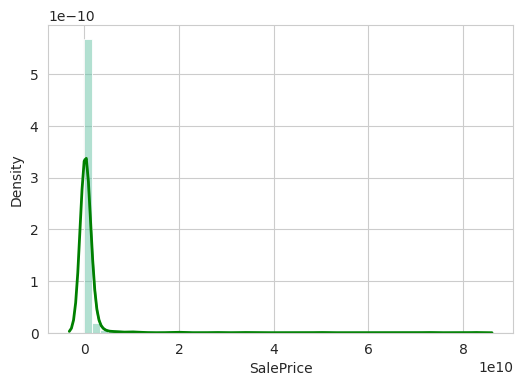

In [ ]:
error = (y_train - model.predict(X_train)) ** 2
fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(error, kde=True, bins=50, ax=ax, stat='density')
sns.kdeplot(error, color='green', linewidth=2, ax=ax);

Как видно из гистограммы, есть примеры с очень большими остатками. Попробуем их выбросить из обучающей выборки. Например, выбросим примеры, остаток у которых больше 0.95-квантили.

In [ ]:
mask = (error < np.quantile(error, 0.95))

In [ ]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(best_alpha))
])

model = pipeline.fit(X_train[mask], y_train[mask])
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % root_mean_squared_error(y_test, y_pred))

Test RMSE = 24963.5948


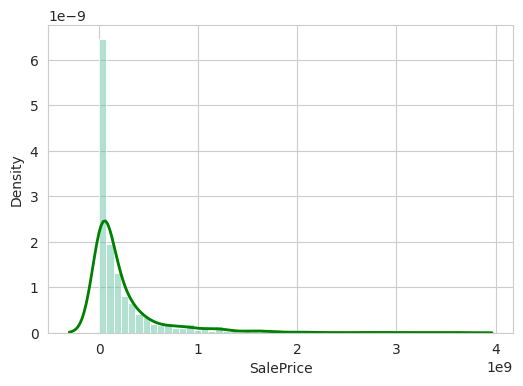

In [ ]:
error = (y_train[mask] - model.predict(X_train[mask])) ** 2

fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(error, kde=True, bins=50, ax=ax, stat='density')
sns.kdeplot(error, color='green', linewidth=2, ax=ax);

Видим, что качество модели заметно улучшилось!

Мы провели только один эксперимент -- ограничены рамками семинара. В реальной жизни нужно осознанно пробовать разные варианты. Например, бывает очень полезно посмотреть на примеры с большими остатками и попытаться понять, почему же модель на них так сильно ошибается: это может дать понимание, как модель можно улучшить.